In [1]:
import os
import numpy as np
import pandas as pd
from ast import literal_eval
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from itertools import cycle

In [2]:
ls = ['-','--',':','-.','-'] #,'--',':','-.','-','--',':','-.','-','--',':','-.','-','--',':','-.','-','--',':','-.']
linecycler = cycle(ls)
ms = ['o', '^', '<', '.', 'v', 'h', '>']
markercycler = cycle(ms)

In [3]:
#preprocessing, due to file size, we include only the preprocesed runtime df in the supplement
result_folder_name = "../results/"
folder = "runtime/"

files = os.listdir(result_folder_name + "/" + folder)

df = pd.DataFrame()

for f in files:
    df = pd.concat(
        [df, pd.read_csv(result_folder_name + "/" + folder + "/" + f, index_col=0)]
    )

df = df.reset_index(drop=True)
df = df.drop(df[df["timeout"] == True].index)
df = df.drop("timeout", axis=1)
df = df.replace({"GasSensors": "Gas", "CIFAR10": "CIFAR"})

for col in ["actual_cps", "detected_cps_at", "detected_cps"]:
    df.loc[:, col] = df.loc[:, col].apply(lambda x: literal_eval(x))

df = df.fillna(0)

df.replace("MMDAW", "MMDEW", inplace=True)
df.replace("NewMA", "NEWMA", inplace=True)

algs = ["MMDEW", "AdwinK", "D3", "IBDD", "NEWMA", "ScanB", "WATCH"]

df["algorithm"] = pd.Categorical(df["algorithm"], algs)

df = df.sort_values("algorithm")

df["dataset"] = df["dataset"].str[8:].astype(int)

df["perinsert"] = df["runtime"] / df["dataset"]

df = df[["algorithm", "dataset", "perinsert"]]

#df.to_csv("../results/runtime/preprocessed.csv")

In [4]:
#df = pd.read_csv("../results/runtime/preprocessed.csv", index_col=0)

In [5]:
mmdaw = df[df["algorithm"] == "MMDEW"].copy()

In [6]:
algs = ["MMDEW", "AdwinK", "D3", "IBDD", "NEWMA", "ScanB", "WATCH"]

df["algorithm"] = pd.Categorical(df["algorithm"], algs)

df = df.sort_values("algorithm")

In [7]:
model = linear_model.LinearRegression()
X = mmdaw["dataset"].values.reshape(-1,1)
y = mmdaw["perinsert"]
model.fit(np.log(X)**2, y)
y1 = model.predict(np.log(X)**2)

In [8]:
np.sum((y-y1)**2)

1.7615225346851933e-07

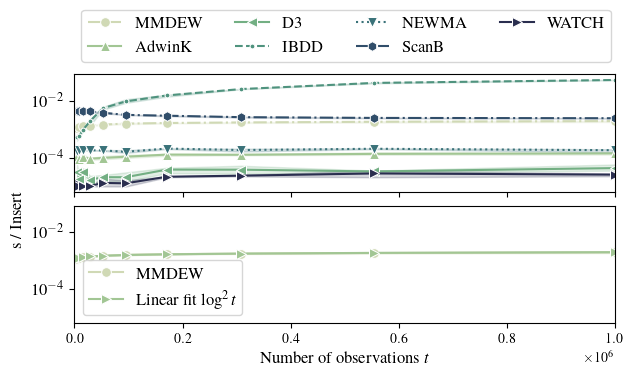

In [10]:
with sns.cubehelix_palette(8, start=0.5, rot=-0.75, gamma=1.2):
    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,sharey=True,figsize=(6,3),layout="constrained")
    for alg in algs:
        sns.lineplot(data=df[df["algorithm"] == alg], x="dataset", y="perinsert", ax=ax1, label=alg, markersize=7, marker=next(markercycler), ls=next(linecycler))
    ax1.set_yscale("log")
    #ax1.set_xlabel("Number of observations ($t$)")
    ax1.set_ylabel("") #"$s$ / Insert", fontsize=12)
    #ax1.legend(bbox_to_anchor=(0.1, 2), ncol=7)
    ax1.set_xlim((0,1000000))
    Line, Label = ax1.get_legend_handles_labels()
    ax1.get_legend().remove()
    fig.legend(Line, Label, loc="upper center", bbox_to_anchor=(0.53, 1.23), ncol=4)

    sns.lineplot(data=mmdaw, x="dataset", y="perinsert", label="MMDEW", ax=ax2, ls=ls[0], marker="o", markersize=7)
    sns.lineplot(x=X.reshape(len(X)), y=y1, label="Linear fit $\\log^2 t$", ax=ax2, ls=next(linecycler), marker=">", markersize=7)
    #ax2.set_xlabel("Number of observations $t$")
    ax2.set_ylabel("")
    fig.supylabel("s / Insert", fontsize=12,x=-0.03)
    ax2.set_xlabel("Number of observations $t$" ,fontsize=12)
    #ax2.legend(bbox_to_anchor=(0.5, 1.15+.4), ncol=2)
    #ax2.set_xlim((0,1000000))

    #plt.tight_layout()
    plt.savefig("../../mmdew-article/fig/runtime_0pad.pdf", bbox_inches="tight", pad_inches=0)